# Two Samples Hypothesis Testing using Resampling

In [1]:
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', 10)

import matplotlib.pyplot as plt
import seaborn as sns;
sns.set_style("whitegrid")  

from statsmodels.distributions.empirical_distribution import ECDF

## Bootstrap Method for two Independent Samples

The bootstrap method idea is simple: "If there is no difference between two treatments, a particular score is just as likely to end up in one group as in the other."

The first step is to shift the two samples we want to compare into others that share the mean.

Let us work with classes C and D.

We will test `Ho: mean(classC) = mean(classD)` without assuming equal variances. 

In [2]:
# Generating the data
np.random.seed(123)
classC = np.random.normal(85, 3, 100)
classD = np.random.normal(90, 3, 95)

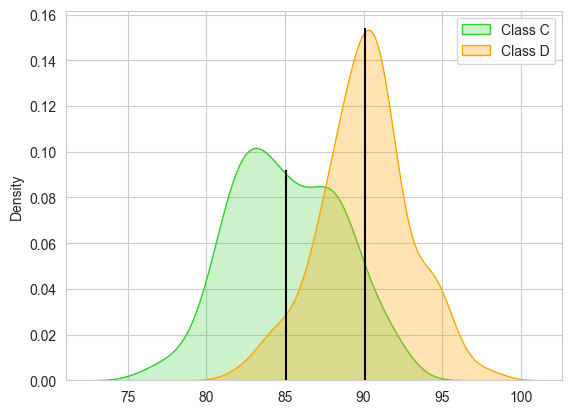

In [3]:
# Plotting the original variables classC and classD
ax=sns.kdeplot(x=classC, color='limegreen', fill=True, label='Class C')
ax.vlines(x=np.mean(classC), ymin=0, ymax=0.092, color='black')
ax=sns.kdeplot(x=classD, color='orange', fill=True, alpha=0.3, label='Class D')
ax.vlines(x=np.mean(classD), ymin=0, ymax=0.154, color='black')
plt.legend();

Notice that the means of `classC` and `classD` are different.

In [4]:
print('Mean of class C = %.2f' % np.mean(classC))
print('Mean of class D = %.2f' % np.mean(classD))

Mean of class C = 85.08
Mean of class D = 90.07


Notice that the number of students in each class is also different.

In [5]:
print('Lenght of class C =', len(classC))
print('Lenght of class D =', len(classD))

Lenght of class C = 100
Lenght of class D = 95


Let us transform the original samples into others that share their means.

In [6]:
# Getting the overall mean
overall_mean = np.concatenate((classC, classD)).mean()
print('Mean of combined sample = %.2f' % overall_mean)

Mean of combined sample = 87.51


In [7]:
# Creating the new variables classC_shifted and classD_shifted that share the mean
classC_shifted = classC - np.mean(classC) + overall_mean
classD_shifted = classD - np.mean(classD) + overall_mean

print('Mean of shifted class C = %.2f' % np.mean(classC_shifted))
print('Mean of shifted class D = %.2f' % np.mean(classD_shifted))

Mean of shifted class C = 87.51
Mean of shifted class D = 87.51


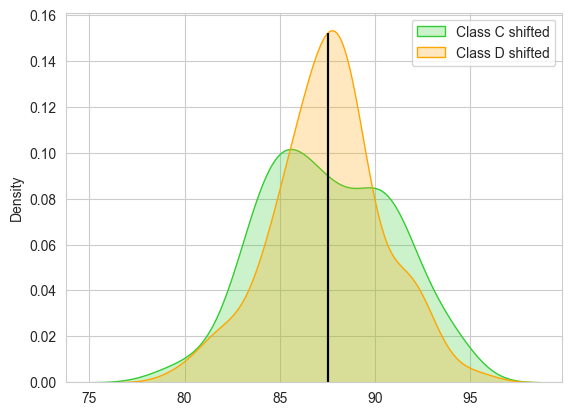

In [8]:
# Ploting the shifted variables
ax=sns.kdeplot(x=classC_shifted, fill=True, color='limegreen', label='Class C shifted')
ax.vlines(x=np.mean(classC_shifted), ymin=0, ymax=0.152, color='black')

ax=sns.kdeplot(x=classD_shifted, fill=True, color='orange', label='Class D shifted')
ax.vlines(x=np.mean(classD_shifted), ymin=0, ymax=0.152, color='black')

plt.legend();

`generate_samples` is the function for generating samples WITH replacement.

In [9]:
def generate_samples(sample_data, num_samples=10000):
    '''
    It generates num_samples samples using sample_data with the bootstrap method 
    and returns a DataFrame where each column is a sample.    
    '''
    sample_size = len(sample_data)
    col = ['S'+str(k) for k in range(num_samples)]
    samp = np.random.choice(sample_data, replace=True, size=sample_size*num_samples)
    df = pd.DataFrame(samp.reshape(sample_size, num_samples), columns=col)
    return(df)  

In [10]:
df_C = generate_samples(classC_shifted, num_samples=10000)
df_D = generate_samples(classD_shifted, num_samples=10000)
display(df_C.head())
display(df_D.head())

,S0,S1,S2,S3,S4,...,S9995,S9996,S9997,S9998,S9999
0,88.669118,88.373198,89.814970,86.098436,89.814970,...,87.566852,81.061081,83.835478,90.638330,86.098436
1,85.232996,84.622880,84.791773,83.548126,87.394890,...,92.413239,84.622880,85.393723,84.138773,88.669118
2,90.212769,89.151799,83.548126,82.911498,92.695040,...,89.852091,89.495050,84.791773,91.917314,85.513676
3,90.963968,88.279317,93.691722,85.513676,87.438920,...,88.373198,85.014282,87.146255,90.151697,91.196094
4,85.517127,84.314017,87.394890,94.144812,90.422418,...,83.451586,84.845117,90.102501,91.902578,89.852091


,S0,S1,S2,S3,S4,...,S9995,S9996,S9997,S9998,S9999
0,82.625474,89.578497,84.141574,90.479920,89.555126,...,87.843784,87.843784,87.012175,89.686350,89.555126
1,87.367825,89.724551,86.444277,85.219262,86.364896,...,90.479920,84.141574,85.849680,86.805463,91.820471
2,87.679384,85.785379,87.679384,93.319937,85.219262,...,87.660425,88.277926,79.770539,86.158664,82.625474
3,85.236052,86.618514,89.724551,88.292879,88.864745,...,86.377230,88.363856,88.032760,93.319937,91.998300
4,88.292879,86.631006,89.878727,89.578497,92.075337,...,85.219262,88.363856,82.625474,91.627762,84.971409


### Statistic: difference in means

In [11]:
# Computing the statistic
dMeans = np.mean(classC) - np.mean(classD)
print('Difference in Means Statistic = %.2f' % dMeans)

Difference in Means Statistic = -4.99


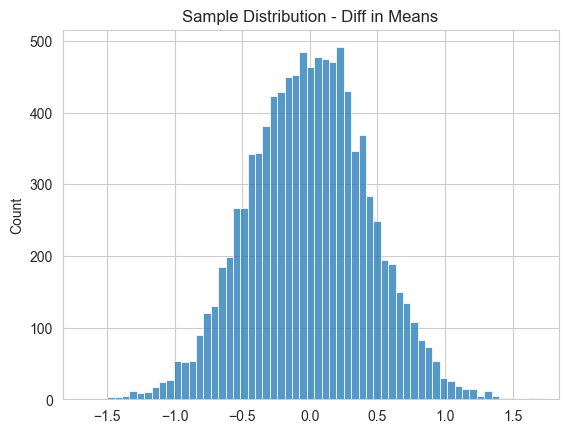

In [12]:
# Computing and ploting the sample distribution of the statistic
sample_distribution_dMeans = df_C.mean() - df_D.mean()
sns.histplot(x=sample_distribution_dMeans).set(title='Sample Distribution - Diff in Means');

In [13]:
def get_p_value(sample_distribution, obs_value, alternative='two-sided'):    
    '''
    It returns the p-value.
    sample_distribution:    the sample distribution
    obs_value:              the observed value     
    alternative:            'two-sided', 'smaller', or 'larger'    
    '''
    ecdf = ECDF(sample_distribution) 
    if alternative=='two-sided':
        p_val = 2*min(ecdf(obs_value), 1 - ecdf(obs_value))        
    elif alternative=='smaller':
        p_val = ecdf(obs_value)
    else:
        p_val = 1-ecdf(obs_value)
    return(p_val)

In [14]:
def graph_hyp_test(sample_value, sample_distribution, alpha=0.05, alternative='two-sided'):
    '''
    It computes and graph the two-samples hypothesis test.
    sample_value:           observed value calculated from the sample
    sample_distribution:    sample distribution calculated from the sample
    alpha:                  significance level
    alternative:            'two-sided', 'smaller', and 'larger'
    '''
    print('--- Hypothesis Test ---')
    # plotting the sample distribution
    sns.kdeplot(x=sample_distribution, color='skyblue', fill=True).set_title('Sample Distribution')  
    # plotting the statistic
    plt.axvline(x=sample_value, ymin=0, ymax= 0.03, color='black', linewidth=6)       
    # get the p-value
    p_val = get_p_value(sample_distribution, sample_value, alternative)
    # plotting the two critical regions
    if alternative=='two-sided':        
        cv1 = np.round(np.percentile(sample_distribution, (alpha/2)*100),2)         # left critical value    
        cv2 = np.round(np.percentile(sample_distribution, 100-(alpha/2)*100),2)     # right critical value    
        plt.axvline(x = cv1, ymin=0, ymax=0.5, color='orangered', linewidth=2)
        plt.axvline(x = cv2, ymin=0, ymax=0.5, color='orangered', linewidth=2);
    # plotting the left critical region
    elif alternative=='smaller':        
        cv1 = np.round(np.percentile(sample_distribution, alpha*100),2)             # left critical value
        plt.axvline(x = cv1, ymin=0, ymax=0.5, color='orangered', linewidth=2)
    # plotting the right critical region
    else:                               
        cv2 = np.round(np.percentile(sample_distribution, 100-alpha*100),2)         # right critical value
        plt.axvline(x = cv2, ymin=0, ymax=0.5, color='orangered', linewidth=2)
    # printing the statistic and the p-value    
    print('Observed Value = %.2f\tp-value = %.4f' %(sample_value, p_val))  

--- Hypothesis Test ---
Observed Value = -4.99	p-value = 0.0000


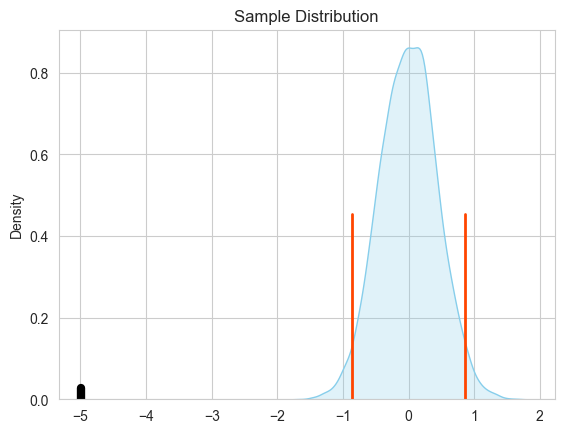

In [15]:
graph_hyp_test(dMeans, sample_distribution_dMeans)

As you can see, significant differences exist between the "classC" and "classD" means.

### Statistic: difference in medians

You can use different statistics with resampling hypothesis test methods like Bootstrap and Permutation. The choice of a statistic depends on what you want to test and the nature of your data. Let's see some examples.

In [16]:
# Computing the statistic
dMedians = np.median(classC) - np.median(classD) 
print('Difference in medians = %.2f' % dMedians)

Difference in medians = -5.44


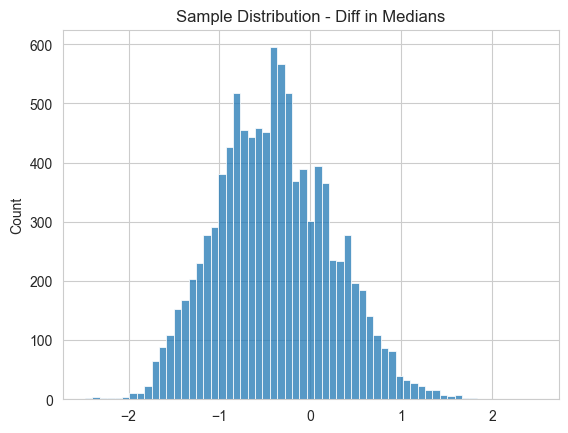

In [17]:
# Computing and ploting the sample distribution of the statistic
sample_distribution_dMedians = df_C.median() - df_D.median()
sns.histplot(x=sample_distribution_dMedians).set(title='Sample Distribution - Diff in Medians');

--- Hypothesis Test ---
Observed Value = -5.44	p-value = 0.0000


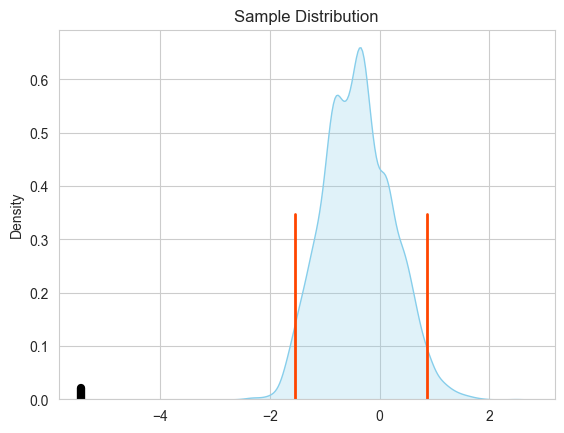

In [18]:
graph_hyp_test(dMedians, sample_distribution_dMedians)

As you can see, significant differences exist between the "classC" and "classD" medians.

### Statistic: t-test

In [19]:
# Computing the t-statistic
t = (classC.mean() - classD.mean()) / np.sqrt((classC.var()/len(classC)) + (classD.var()/len(classD)))
print('t-statistic = %.2f' % t)

t-statistic = -11.22


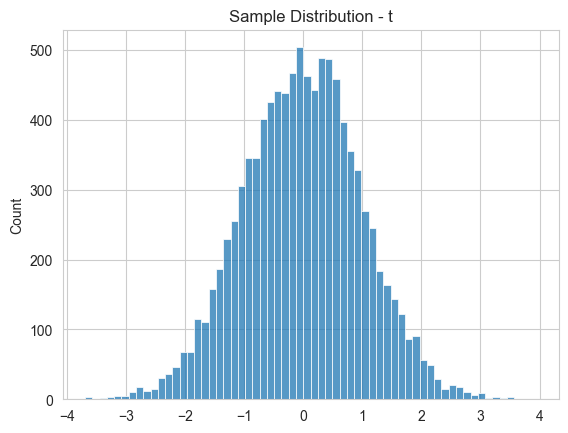

In [20]:
# Computing and ploting the sample distribution of the t-statistic
sample_distribution_t = (df_C.mean() - df_D.mean()) / np.sqrt((df_C.var()/df_C.shape[0]) + (df_D.var()/df_D.shape[0]))
sns.histplot(x=sample_distribution_t).set(title='Sample Distribution - t');

--- Hypothesis Test ---
Observed Value = -11.22	p-value = 0.0000


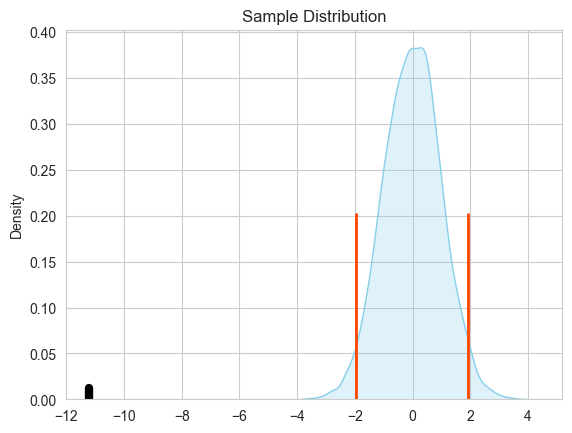

In [21]:
graph_hyp_test(t, sample_distribution_t)

As you can see, significant differences exist between the "classC" and "classD" variables.

## Bootstrap method for two paired samples

In [22]:
# Generating the data
np.random.seed(12)
grade_before = np.random.normal(80, 4, 90)
grade_after  = np.random.normal(86, 3, 90)

When working with paired data, we cannot break the link between the values. 

If Ho is true, there are no differences between both grades. 

Let's use the variables `grade_before` and `grade_after`.

- Ho: mean_grade_after  = mean_grade_before  or  mean_grade_after - mean_grade_before  = 0
- Ha: mean_grade_after != mean_grade_before  or  mean_grade_after - mean_grade_before != 0

In [23]:
# Creating a new variable: the difference between both grades
diff = grade_after - grade_before
stat = diff.mean()
print('Statistic = %.2f' % stat)

Statistic = 5.97


In [24]:
# Generating the samples
diff_Ho = diff - diff.mean() 
df_pair = generate_samples(diff_Ho, num_samples=10000) 
print(df_pair.shape)
df_pair.head()

(90, 10000)


,S0,S1,S2,S3,S4,...,S9995,S9996,S9997,S9998,S9999
0,-1.179779,-12.126505,8.350729,-3.009343,-9.272730,...,-2.371376,0.371919,-10.866465,-0.950226,-0.950226
1,-9.272730,-10.866465,2.563772,-1.656786,-1.781057,...,-7.331027,-7.331027,8.017791,-6.690379,-0.051110
2,-2.290342,-1.212190,9.237885,-1.608691,7.115950,...,-0.021593,-4.369828,3.830936,7.115950,8.350729
3,-0.051110,-10.866465,-9.264579,-6.094783,-9.272730,...,3.486442,5.049180,-1.100901,-3.058532,9.000508
4,-2.168348,6.709193,3.486442,-0.005875,1.645534,...,0.414731,-5.594597,3.477324,0.788049,3.486442


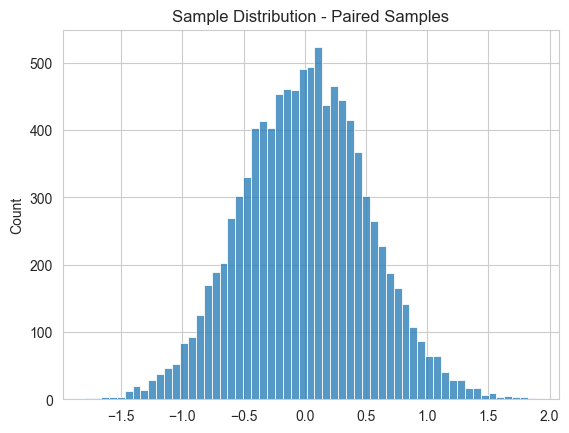

In [25]:
# Computing and ploting the sample distribution of the statistic
sample_distribution_pair = np.array(df_pair.mean())
sns.histplot(x=sample_distribution_pair).set(title='Sample Distribution - Paired Samples');

--- Hypothesis Test ---
Observed Value = 5.97	p-value = 0.0000


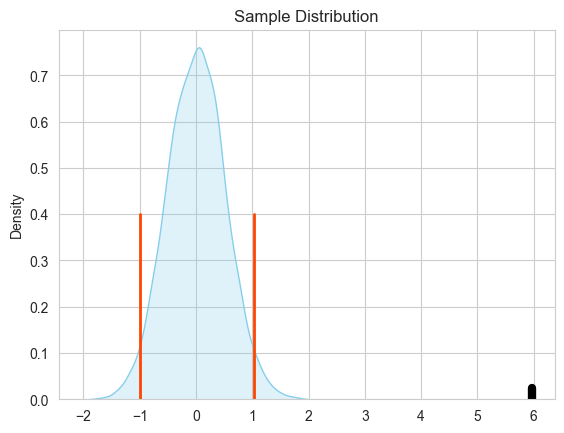

In [26]:
graph_hyp_test(stat, sample_distribution_pair)

As you can see, significant differences exist between the "grade_after" and "grade_before" variables.

## Permutation Method for two Independent Samples

Let us use a permutation test to determine whether the two means (classC and classD) are diferent from each other.

The method is very similar to the bootstrap, but a fundamental difference is that the bootstrap resamples with replacement and the permutation test does not. 

Hypothesis

- Ho: mean_C  = mean_D (mean_C-mean_D = 0)
- Ha: mean_C != mean_D (mean_C-mean_D != 0)  

Let us pool all the data together and randomly split the data into two groups: classC and classD.

We will repeat the process many times (about 10000)

**Main idea**: If there is truly no difference between the average grades of classC and classD, there will be no differences between the average grades of the generated groups.

In [27]:
def shuffle_2_samples(sample1, sample2, num_samples=10000):
    '''
    It returns two DataFrames, where each column is a permutation (sampling without replacement)
    '''
    pool = np.concatenate([sample1, sample2])  
    # Creating a DataFrame with one column
    df = pd.DataFrame(pool)
    # Replicating the column num_samples times
    df = (pd.concat([df]*num_samples, axis=1, ignore_index=True)).rename(lambda c: 'S'+str(c), axis=1)
    # Shuffling the data
    df = df.apply(np.random.permutation)
    # Creating two new DataFrames
    df1 = df[df.index < len(sample1)]
    df2 = df[df.index >= len(sample1)]
    return(df1, df2)

In [28]:
# generating samples for classC and classD
df_C_p, df_D_p = shuffle_2_samples(classC, classD)
display(df_C_p.head())
display(df_D_p.head())

,S0,S1,S2,S3,S4,...,S9995,S9996,S9997,S9998,S9999
0,91.996960,84.414073,86.138202,90.836223,90.538648,...,90.362242,84.233142,87.064668,94.556597,88.354074
1,95.878234,89.774638,86.714921,91.278440,88.308228,...,91.174753,94.556597,85.089050,89.172642,92.113422
2,88.208178,83.862471,79.816992,91.174753,85.493324,...,83.827301,87.721316,85.543105,83.862471,91.503747
3,89.910096,90.965060,83.264199,81.743108,84.414073,...,85.493324,90.060948,87.936208,90.218722,81.743108
4,86.699871,81.362431,87.794349,88.343676,94.556597,...,80.909585,88.407976,82.328836,92.113422,89.002574


,S0,S1,S2,S3,S4,...,S9995,S9996,S9997,S9998,S9999
100,81.746296,84.479093,88.166324,85.089050,84.369394,...,88.938000,81.708391,79.816992,86.941035,89.251897
101,88.012162,91.423042,89.926122,81.238358,87.777559,...,84.479093,90.419934,88.797809,89.982857,87.384588
102,87.992036,91.661568,87.529706,94.415788,82.802614,...,83.713262,88.527487,91.714430,84.579794,89.926122
103,90.362242,89.982857,87.777559,82.963342,87.212106,...,92.177096,90.998295,81.883635,87.992036,86.015767
104,89.621647,87.782387,92.136794,80.182112,81.405097,...,86.721418,89.363760,83.713262,92.136794,82.192498


### Statistic: difference in means

In [29]:
# Calculating the difference in means
dMeans_p = np.mean(classC) - np.mean(classD)
print('Difference in means statistic = %.2f' % dMeans_p)

Difference in means statistic = -4.99


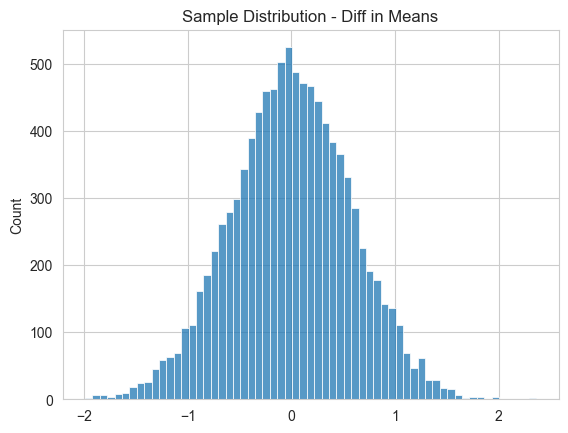

In [30]:
# Calculating and ploting the sample distribution of the statistic
sample_distribution_dMeans_p = df_C_p.mean() - df_D_p.mean()
sns.histplot(x=sample_distribution_dMeans_p).set(title='Sample Distribution - Diff in Means');

--- Hypothesis Test ---
Observed Value = -4.99	p-value = 0.0000


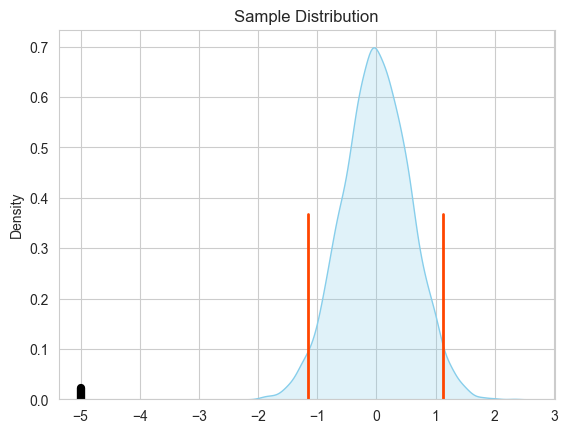

In [31]:
graph_hyp_test(dMeans_p, sample_distribution_dMeans_p)

As you can see, significant differences exist between the "classC" and "classD" means.

With the permutation test, you can create new hypothesis tests by using different statistics.

## Permutation Test for two Paired Samples Hypothesis Test

Remember:
- Ho: mean(grade_before) == mean(grade_after)
- Ha: mean(grade_before) != mean(grade_after)

mean(grade_before) == mean(grade_after) is equivalent to diff == 0
diff = mean(grade_before) - mean(grade_after)

We can reformulate the hypothesis as:
- Ho: diff == 0
- Ha: diff != 0

If we swap some before and after values, the result will be the same under Ho. That is the main idea of the permutation test for paired data.

In [32]:
def shuffle_1_sample(sample, num_samples=10000):
    '''
    Generation of samples for the paired sample permutation method.
    '''
    # Creating a DataFrame with the original sample (one column)
    df = pd.DataFrame(sample)
    # Replicating the column num_samples times
    df = (pd.concat([df]*num_samples, axis=1, ignore_index=True)).rename(lambda c: 'S'+str(c), axis=1)
    # Changing the sign to random numbers in the DataFrame 
    df = df.applymap(lambda x: x if np.random.rand() < 0.5 else -x)
    return(df)

In [33]:
df_pair_p = shuffle_1_sample(diff, num_samples=10000)
print(df_pair_p.shape)
display(df_pair_p.head())

(90, 10000)


,S0,S1,S2,S3,S4,...,S9995,S9996,S9997,S9998,S9999
0,2.914417,2.914417,2.914417,-2.914417,2.914417,...,2.914417,2.914417,-2.914417,-2.914417,2.914417
1,4.948033,-4.948033,4.948033,4.948033,4.948033,...,4.948033,4.948033,4.948033,-4.948033,-4.948033
2,2.963606,-2.963606,2.963606,-2.963606,2.963606,...,-2.963606,-2.963606,-2.963606,2.963606,-2.963606
3,-15.210834,-15.210834,15.210834,-15.210834,15.210834,...,-15.210834,15.210834,15.210834,15.210834,15.210834
4,-3.804602,-3.804602,-3.804602,-3.804602,3.804602,...,-3.804602,3.804602,3.804602,3.804602,-3.804602


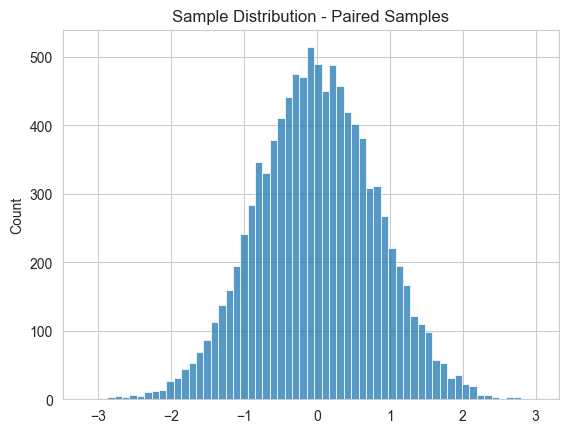

In [34]:
# Computing and ploting the sample distribution of the statistic
sample_distribution_pair_p = np.array(df_pair_p.mean())
sns.histplot(x=sample_distribution_pair_p).set(title='Sample Distribution - Paired Samples');

--- Hypothesis Test ---
Observed Value = 5.97	p-value = 0.0000


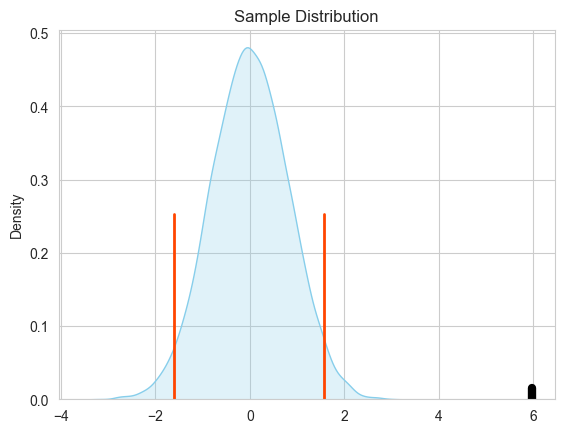

In [35]:
graph_hyp_test(stat, sample_distribution_pair_p)

## References

- Bradley, E., Tibshirani, R.J. (1993) An Introduction to the Bootstrap. chapter 16, Boca Raton: Chapman & Hall/CRC.
- Davison, A.C., Hinkley, D.V. (1997) Bootstrap Methods and their Applications, chapter 4, Cambridge: Cambridge University Press.
- Good, P. (2005) Permutation, Parametric, and Bootstrap Tests of Hypothesis, Third Edition, USA: Springer Series in Statistics